In [1]:
import pandas as pd 
import numpy as np 

# Visualisation 
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import confusion_matrix, accuracy_score

# Keras for deep learning models
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenising text data
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For sequence padding to uniform length
from tensorflow.keras.models import Sequential  # For sequential model architecture
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout  # Layers for model building
from tensorflow.keras.regularizers import l2  # L2 regularisation to prevent overfitting

In [2]:
def prepare_data():
    
    # Load the dataset from a CSV file
    data = pd.read_csv('car-reviews.csv')
    
    # Splitting the data into positive and negative reviews based on a predetermined index
    positive_data = data[691:]  
    negative_data = data[:691]  
    
    # Further split positive and negative datasets into training and testing subsets
    train_positive = positive_data[:553]
    test_positive = positive_data[553:] 
    train_negative = negative_data[:553]
    test_negative = negative_data[553:]  
    
    # Concatenate the positive and negative training data, and do the same for testing data
    training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
    testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)
    
    # Convert the 'Sentiment' column into a binary format: 1 for positive, 0 for negative
    training_data['Sentiment'] = np.where(training_data['Sentiment'] == 'Pos', 1, 0)
    testing_data['Sentiment'] = np.where(testing_data['Sentiment'] == 'Pos', 1, 0)

    # Extract reviews (as text) and their corresponding labels for training and testing
    training_texts = list(training_data['Review'])
    training_labels = list(training_data['Sentiment'])
    test_texts = list(testing_data['Review'])
    test_labels = list(testing_data['Sentiment'])

    # Return the processed text and labels for training and testing
    return training_texts, training_labels, test_texts, test_labels

In [3]:
def tokenisation():
    
    training_texts, training_labels, test_texts, test_labels = prepare_data()
    
    # Initialise the tokenizer with a maximum number of words to keep, based on word frequency
    tokenizer = Tokenizer(num_words=10000)  # Setting the size of the vocabulary to the top 10,000 words
    tokenizer.fit_on_texts(training_texts)  # Updates internal vocabulary based on the list of texts
    
    # Convert the list of texts to a sequence of integers
    train_sequences = tokenizer.texts_to_sequences(training_texts)  # Transforms each text in training_texts to a sequence of integers
    train_data = pad_sequences(train_sequences, maxlen=100)  # Ensures all sequences in a list have the same length by padding/truncating
    train_labels = np.array(training_labels)  
    
    # Repeat the tokenisation and padding process for the testing set
    test_sequences = tokenizer.texts_to_sequences(test_texts) 
    test_data = pad_sequences(test_sequences, maxlen=100) 
    test_labels = np.array(test_labels)  

    return train_data, train_labels, test_data, test_labels

In [7]:
def LTSM_model(train_data, train_labels, test_data, test_labels, embedding_dim, lstm_unit, dropout_rate, reg_strength):
    
    """
    Parameters:
        - embedding_dim: Dimension of the embedding layer
        - lstm_unit: Number of units in the LSTM layer
        - dropout_rate: Dropout rate for regularization
        - reg_strength: Strength of L2 regularization
    """

    model = Sequential([
        
        # Input layer specifies the shape of input data (100 set = sequence length)
        Input(shape=(100,)),
        
        # Embedding layer to turn positive integers (indexes) into dense vectors of fixed size, 10000 is the size of the vocabulary
        Embedding(input_dim=10000, output_dim=embedding_dim),
        
        # LSTM layer with specified units and dropout for regularization
        LSTM(lstm_unit, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        
        # Dense output layer with sigmoid activation for binary classification
        Dense(1, activation='sigmoid', kernel_regularizer=l2(reg_strength))
    ])
    
    # Compile the model with Adam optimizer and binary crossentropy loss, tracking accuracy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the training data, with a validation split to monitor overfitting
    history = model.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split=0.2)

    # Predict probabilities on the test set and convert to class labels (1 or 0) based on a 0.5 threshold
    test_predictions_proba = model.predict(test_data)
    test_predictions = (test_predictions_proba > 0.5).astype("int32").flatten()
    
    # Generating the confusion matrix from test labels and predictions
    conf_matrix = confusion_matrix(test_labels, test_predictions)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print('\n')
    display(conf_matrix_df)

    accuracy = accuracy_score(test_labels, test_predictions)
    print('\n')
    print('Accuracy: ', round(accuracy, 3))
    print('\n')

    # Call the model evaluation function to plot training history
    model_evaluation(history)

In [8]:
def model_evaluation(history):
    
    # Training history data
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    epochs = range(1, len(training_accuracy) + 1)
    
    plt.figure(figsize=(10, 4))
    
    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, label='Training Loss', marker='o')
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6145 - loss: 1.3184 - val_accuracy: 0.0000e+00 - val_loss: 1.4163
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6088 - loss: 1.1448 - val_accuracy: 0.0045 - val_loss: 1.2787
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6501 - loss: 0.9864 - val_accuracy: 0.2523 - val_loss: 1.1922
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8404 - loss: 0.7732 - val_accuracy: 0.3739 - val_loss: 1.3197
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9007 - loss: 0.6034 - val_accuracy: 0.3649 - val_loss: 1.3485
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9462 - loss: 0.4854 - val_accuracy: 0.6081 - val_loss: 1.0506
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9596 - loss: 0.4129 - val_accuracy: 0.6441 - val_loss: 1.0220
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9580 - loss: 0.3801 - val_accuracy: 0.6081

,Predicted Negative,Predicted Positive
Actual Negative,51,87
Actual Positive,21,117




Accuracy:  0.609




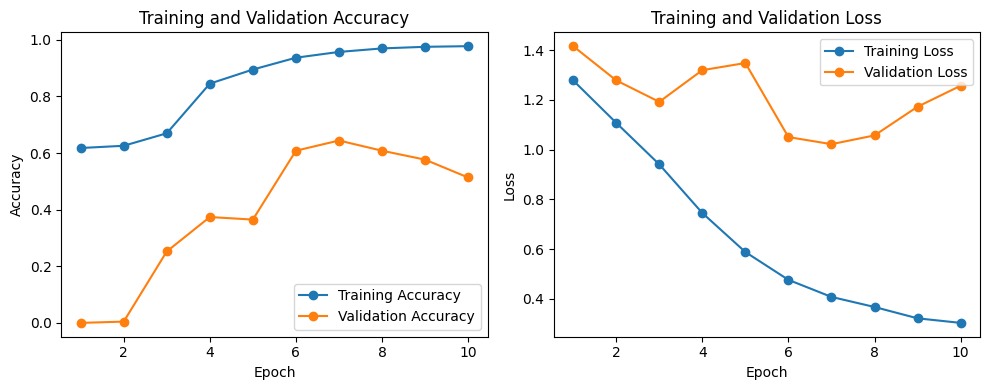

In [9]:
train_data, train_labels, test_data, test_labels = tokenisation()
LTSM_model(train_data, train_labels, test_data, test_labels, embedding_dim = 62, lstm_unit = 48, dropout_rate = 0.2, reg_strength = 0.3)